In [ ]:
!pip -q install condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:08
🔁 Restarting kernel...


In [ ]:
# Add channels
!conda config --add channels astra-toolbox
!conda config --add channels conda-forge

# Astra
!conda install -y astra-toolbox imageio matplotlib

Channels:
 - conda-forge
 - astra-toolbox
Platform: linux-64
Solving environment: \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - astra-toolbox
    - imageio
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alsa-lib-1.2.14            |       hb9d3cd8_0         553 KB  conda-forge
    astra-toolbox-2.3.1        |cudapy311h839ca5e_100         447 KB  conda-forge
    brotli-1.1.0               |       hb9d3cd8_2          19 KB  conda-forge
    brotli-bin-1.1.0           |       hb9d3cd8_2          18 KB  conda-forge
    ca-certificates-2025.8.3   |       hbd8a1cb_0         151 KB  conda-forge
    cairo-1.18.4               |       h3394656_0         955 KB  conda-forge
    certifi-2025.8.3           |     pyhd8ed1ab_0         155 KB  conda-forge
    conda-24.11.3              |  py311h38be061_0         1.1 MB

In [ ]:
import os, numpy as np, imageio.v2 as iio
from glob import glob

# 1) unzip
!unzip -q /content/projections.zip -d /content/projections

# 2) folder
IMG_DIR = "/content/projections/projections_folder"

# 3) file list (Object_BH_Proj000.png ... Object_BH_Proj511.png)
paths = [os.path.join(IMG_DIR, f"Object_BH_Proj{idx:03d}.png") for idx in range(0, 512)]
assert all(os.path.exists(p) for p in paths), "Some projection files are missing."

# 4) load -> projs: (angles, detV, detU)
imgs = [iio.imread(p).astype(np.float32) for p in paths]
if imgs[0].ndim == 3:  # RGB ise griye indir
    imgs = [im.mean(axis=2) for im in imgs]
projs = np.stack(imgs, axis=0)  # (512, 1024, 1024)
print("projs:", projs.shape)

# 5) angles (512 view over 360°)
angles = np.linspace(0.0, 2*np.pi, projs.shape[0], endpoint=False).astype(np.float32)

# 6) air normalization + log (line integrals)
I  = np.clip(projs, 1e-6, None)
I0 = np.percentile(I, 99.9, axis=(1,2), keepdims=True).astype(np.float32)
sino3d = -np.log(np.clip(I / I0, 1e-6, None)).astype(np.float32)  # (512,1024,1024)

# 7) save for Astra
np.save("/content/sino3d.npy", sino3d)
np.save("/content/angles.npy", angles)
print("saved:", sino3d.shape, angles.shape)

projs: (512, 1024, 1024)
saved: (512, 1024, 1024) (512,)


In [ ]:
%%bash
cat > /content/run_fdk.py << 'PY'
import numpy as np, astra, os
import imageio.v2 as iio

# ---- load ----
sino_ARC = np.load("/content/sino3d.npy").astype(np.float32)   # (A,R,C)
angles   = np.load("/content/angles.npy").astype(np.float32)   # (A,)
A, R, C  = map(int, sino_ARC.shape)

# ASTRA 3D data order: (R, A, C)
sino_RAC = np.transpose(sino_ARC, (1, 0, 2)).copy(order="C")

# ---- geometry (PDF) ----
DSO, DSD = 100.0, 1500.0
pix = 0.8
proj_geom = {
    'type': 'cone',
    'DetectorSpacingX': pix,
    'DetectorSpacingY': pix,
    'DetectorRowCount': R,
    'DetectorColCount': C,
    'ProjectionAngles': angles,
    'DistanceOriginSource': DSO,
    'DistanceOriginDetector': DSD - DSO,
}

# ---- volume geometry: [-20,20] mm cube ----
nx = ny = nz = 512
vol_geom = astra.create_vol_geom(nx, ny, nz,
                                 -20, 20,
                                 -20, 20,
                                 -20, 20)

# ---- reconstruct ----
sino_id = astra.data3d.create('-sino', proj_geom, sino_RAC)
vol_id  = astra.data3d.create('-vol',  vol_geom)
cfg = astra.astra_dict('FDK_CUDA')
cfg['ProjectionDataId']     = sino_id
cfg['ReconstructionDataId'] = vol_id
alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id)
vol = astra.data3d.get(vol_id).astype(np.float32)

# ---- save ----
os.makedirs("/content/out", exist_ok=True)
np.save("/content/out/vol_fdk.npy", vol)

def save_slice(img, path, flipx=False, flipy=False):
    if flipx: img = img[:, ::-1]
    if flipy: img = img[::-1, :]
    vmin = 0.15*float(img.min()); vmax = 0.15*float(img.max())
    img = np.clip(img, vmin, vmax)
    img = ((img - vmin)/(vmax - vmin + 1e-12)*255).astype(np.uint8)
    iio.imwrite(path, img)

z, y, x = np.array(vol.shape)//2

# (a) x-axis cross-section (yz plane) → PDF version
save_slice(vol[:, :, x], "/content/out/fdk_xaxis.png", flipx=True)

# (b) y-axis cross-section (xz plane) → PDF version
save_slice(vol[:, y, :], "/content/out/fdk_yaxis.png", flipx=False)

# (c) z-axis cross-section (axial) → PDF version
save_slice(vol[z, :, :], "/content/out/fdk_axial.png", flipx=True)

astra.algorithm.delete(alg_id)
astra.data3d.delete(sino_id); astra.data3d.delete(vol_id)
PY
echo "run_fdk.py written (axis-wise flip to match PDF)."


run_fdk.py written (axis-wise flip to match PDF).


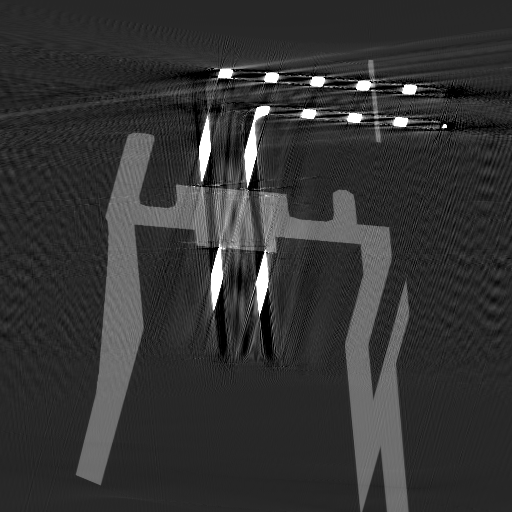

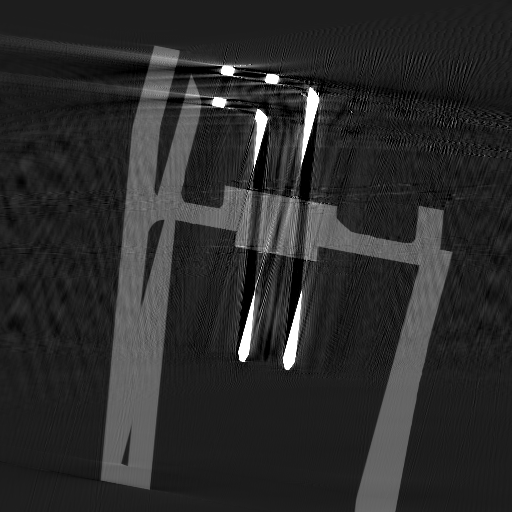

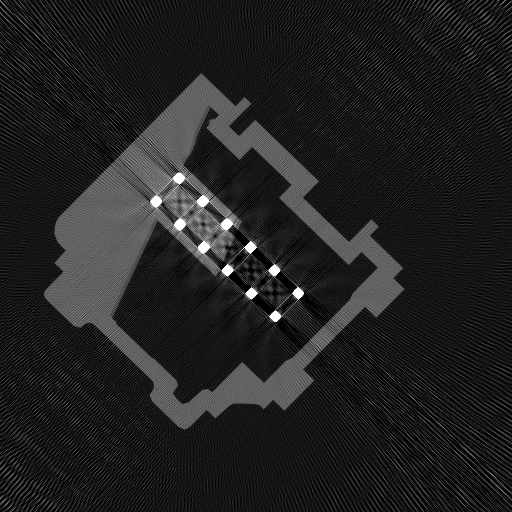

In [ ]:
!conda run -n base python /content/run_fdk.py
from IPython.display import Image, display
for n in ["fdk_xaxis.png","fdk_yaxis.png","fdk_axial.png"]:
    display(Image(f"/content/out/{n}"))

In [ ]:
%%bash
cat > /content/run_iterative.py << 'PY'
import numpy as np, astra, os
import imageio.v2 as iio

# load
sino_ARC = np.load("/content/sino3d.npy").astype(np.float32)   # (A,R,C)
angles   = np.load("/content/angles.npy").astype(np.float32)   # (A,)
A, R, C  = map(int, sino_ARC.shape)
sino_RAC = np.transpose(sino_ARC, (1, 0, 2)).copy(order="C")   # (R,A,C)

# geometry
DSO, DSD = 100.0, 1500.0
pix = 0.8
proj_geom = {
    'type': 'cone',
    'DetectorSpacingX': pix,
    'DetectorSpacingY': pix,
    'DetectorRowCount': R,
    'DetectorColCount': C,
    'ProjectionAngles': angles,
    'DistanceOriginSource': DSO,
    'DistanceOriginDetector': DSD - DSO,
}

# volume: [-20,20] mm
nx = ny = nz = 512
vol_geom = astra.create_vol_geom(nx, ny, nz, -20, 20, -20, 20, -20, 20)

# reconstruct (SIRT3D_CUDA, 200 it)
sino_id = astra.data3d.create('-sino', proj_geom, sino_RAC)
vol_id  = astra.data3d.create('-vol',  vol_geom)
cfg = astra.astra_dict('SIRT3D_CUDA')
cfg['ProjectionDataId']     = sino_id
cfg['ReconstructionDataId'] = vol_id
alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id, 200)
vol = astra.data3d.get(vol_id).astype(np.float32)

# save
os.makedirs("/content/out", exist_ok=True)
np.save("/content/out/vol_sirt.npy", vol)

def save_slice(img, path, flipx=False, flipy=False):
    if flipx: img = img[:, ::-1]
    if flipy: img = img[::-1, :]
    vmin = 0.15*float(img.min()); vmax = 0.15*float(img.max())
    img = np.clip(img, vmin, vmax)
    img = ((img - vmin)/(vmax - vmin + 1e-12)*255).astype(np.uint8)
    iio.imwrite(path, img)

z, y, x = np.array(vol.shape)//2
save_slice(vol[:, :, x], "/content/out/sirt_xaxis.png", flipx=True)   # yz
save_slice(vol[:, y, :], "/content/out/sirt_yaxis.png", flipx=False)  # xz
save_slice(vol[z, :, :], "/content/out/sirt_axial.png", flipx=True)   # axial

astra.algorithm.delete(alg_id)
astra.data3d.delete(sino_id); astra.data3d.delete(vol_id)
PY

echo "run_iterative.py written (SIRT3D_CUDA, /content paths)."
python /content/run_iterative.py
echo "Outputs:"
ls -1 /content/out


In [ ]:
!conda run -n base python /content/run_iterative.py
from IPython.display import Image, display
for n in ["fdk_xaxis.png","fdk_yaxis.png","fdk_axial.png"]:
    display(Image(f"/content/out/{n}"))